In [74]:
import pandas as pd
import numpy as np
import csv
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import string
from io import StringIO
import re
import pprint
from string import punctuation
from __future__ import division

In [75]:
#Load dataset with hand-coded rating classifications 

with open('Sjogrens_500.csv', 'rb') as f:
  contents = f.read()

s = str(contents, 'utf-8', errors="ignore")
data = StringIO(s)
df=pd.read_csv(data)
df.columns = df.columns.to_series().apply(lambda x: x.strip())
df = df[['Emotional', 'post_text']]   #Edit for 'Informational/Emotional'
df.head()

,Emotional,post_text
0,4.0,"Hi everybody!\n\nI write from Galicia, in the ..."
1,4.0,Hello and Welcome Lou.\n\n\nI am sorry to hear...
2,1.0,"Interesting - my ANA was/is high, but SS antib..."
3,1.0,My blood work was not diffinitive. I was DX'd ...
4,5.0,"Lou, \n\nI want to be a support to you as well..."


In [76]:
#Clean and format column names

df = df.dropna()
df = df.rename(columns = {'post_text': 'text','Emotional': 'target'})  #Edit for 'Informationl/Emotional'
df.head()

,target,text
0,4.0,"Hi everybody!\n\nI write from Galicia, in the ..."
1,4.0,Hello and Welcome Lou.\n\n\nI am sorry to hear...
2,1.0,"Interesting - my ANA was/is high, but SS antib..."
3,1.0,My blood work was not diffinitive. I was DX'd ...
4,5.0,"Lou, \n\nI want to be a support to you as well..."


In [77]:
#Find the distribution of rating classifications in the dataset
df.groupby('target').describe()

text                                                               
       count unique                                                top freq
target                                                                     
1.0      253    253  I had my second set of plugs put in this week....    1
2.0       97     97  Mat, \n̴_ ̴_ ̴_I'm going on my 3rd year readin...    1
3.0       34     34  They don't know for sure what causes some peop...    1
4.0       63     63  Cindy-\nThe steroids should help with some of ...    1
5.0       51     51  So glad they caught the lymphoma on time Lotus...    1

In [78]:
#Calculate null accuracy: ie. accuracy that could be achieved by always predicting the most frequent class
null_accuracy_Emotional = (253 / len(df.target)) * 100
print('Null Accuracy: %.2f%%' % (null_accuracy_Emotional))

Null Accuracy: 50.80%


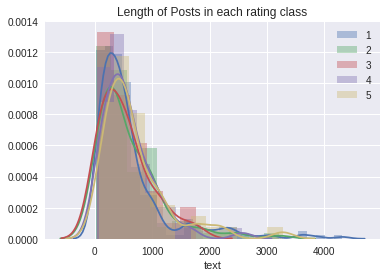

In [79]:
#### Visualize distribution of features in dataset ###

#Length of post (number of characters)
s1 = df[df['target'] == 1]['text'].str.len()
sns.distplot(s1, label='1')
s2 = df[df['target'] == 2]['text'].str.len()
sns.distplot(s2, label='2')
s3 = df[df['target'] == 3]['text'].str.len()
sns.distplot(s3, label='3')
s4 = df[df['target'] == 4]['text'].str.len()
sns.distplot(s4, label='4')
s5 = df[df['target'] == 5]['text'].str.len()
sns.distplot(s5, label='5')

plt.title('Length of Posts in each rating class')
plt.legend()

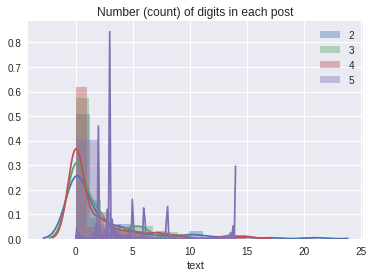

In [80]:
# Number of digits in post
# \d matches a digit, and \D matches anything else

#s1 = df[df['target'] == 1]['text'].str.replace(r'\D+', '').str.len()
#sns.distplot(s1, label='1')
s2 = df[df['target'] == 2]['text'].str.replace(r'\D+', '').str.len()
sns.distplot(s2, label='2')
s3 = df[df['target'] == 3]['text'].str.replace(r'\D+', '').str.len()
sns.distplot(s3, label='3')
s4 = df[df['target'] == 4]['text'].str.replace(r'\D+', '').str.len()
sns.distplot(s4, label='4')
s5 = df[df['target'] == 5]['text'].str.replace(r'\D+', '').str.len()
sns.distplot(s5, label='5')

plt.title('Number (count) of digits in each post')
plt.legend()

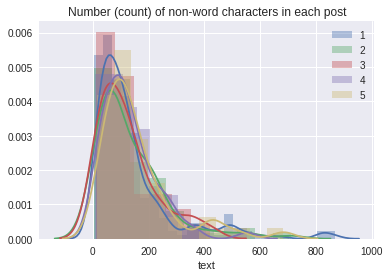

In [81]:
# Matches of non-word characters (anything other than a letter, digit or underscore.)
# \W matches a word characater, \w matches anything else


s1 = df[df['target'] == 1]['text'].str.replace(r'\w+', '').str.len()
sns.distplot(s1, label='1')
s2 = df[df['target'] == 2]['text'].str.replace(r'\w+', '').str.len()
sns.distplot(s2, label='2')
s3 = df[df['target'] == 3]['text'].str.replace(r'\w+', '').str.len()
sns.distplot(s3, label='3')
s4 = df[df['target'] == 4]['text'].str.replace(r'\w+', '').str.len()
sns.distplot(s4, label='4')
s5 = df[df['target'] == 5]['text'].str.replace(r'\w+', '').str.len()
sns.distplot(s5, label='5')

plt.title('Number (count) of non-word characters in each post')
plt.legend()

In [82]:
#Split the dataset into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], 
                                                    df['target'], 
                                                    random_state=0)

In [83]:
'''Vectorize the 'text' input--ie, each word in the training set corpus becomes a feature, and each post  
is represented as a vector with an integer count for each word. aka Document Term Matrix.
Sticking with just this matrix as an input for the model is a "Bag of Words" approach to text classification'''

from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(min_df = 3).fit(X_train)
print('Vocabulary len:', len(vect.get_feature_names()))
print('Longest word:', max(vect.vocabulary_, key=len))

X_train_vectorized = vect.transform(X_train)


Vocabulary len: 1572
Longest word: gastroenterologist


In [84]:
#Fit the model with the training set

from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB(alpha=0.1)
model.fit(X_train_vectorized, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [85]:
#Run the following just to explore which terms have highest and lowest frequency metrics in the model

# get the feature names as numpy array
feature_names = np.array(vect.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['challenges' 'met' 'protect' 'feelings' 'susan' 'project' 'surprised'
 'relate' 'overwhelming' 'cleaning']

Largest Coefs: 
['the' 'and' 'to' 'my' 'it' 'of' 'in' 'have' 'is' 'that']


In [86]:
#Calculate accuracy of the model

from sklearn.metrics import accuracy_score

y_pred = model.predict(vect.transform(X_test))
print('Model Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))

Model Accuracy: 61.60%


In [90]:
#Run if you want to look at the actual predicted ratings
y_pred


array([ 1.,  5.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  5.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  2.,  1.,  1.,  2.,  1.,  1.,  1.,  2.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  5.,  1.,  1.,  1.,  1.,  5.,  1.,  1.,  1.,
        2.,  5.,  1.,  5.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  5.,  1.,
        2.,  1.,  1.,  5.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  5.,  1.,  1.,  5.,  1.,  1.,  1.,
        1.,  2.,  1.,  4.,  2.,  1.,  1.,  1.])

In [ ]:
### Add Additional features to model? 

'''use these additional features:

1. the length of document (number of characters) 
    --based on earlier exploration, unlikely to distinguish between rating classes
2. number of digits per document -- maybe
3. number of non-word characters (anything other than a letter, digit or underscore.)  
    --also unlikely to distinguish, based on earlier exploration'''

In [45]:
#Function to add features: Returns a sparse feature matrix with the added feature.

def add_feature(X, feature_to_add):
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [46]:
#Play around with these features, to get best accuracy

X_train_vectorized = vect.transform(X_train)
#X_train_vectorized = add_feature(X_train_vectorized, X_train.str.len())
X_train_vectorized = add_feature(X_train_vectorized, X_train.str.replace(r'\D+', '').str.len())
#X_train_vectorized = add_feature(X_train_vectorized, X_train.str.replace(r'\w+', '').str.len())

In [47]:
#Fit the model

model = MultinomialNB(alpha=0.1)
model.fit(X_train_vectorized, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [48]:
#Add the same features to the test set

X_test_vectorized = vect.transform(X_test)
#X_test_vectorized = add_feature(X_test_vectorized, X_test.str.len())
X_test_vectorized = add_feature(X_test_vectorized, X_test.str.replace(r'\D+', '').str.len())
#X_test_vectorized = add_feature(X_test_vectorized, X_test.str.replace(r'\w+', '').str.len())


In [49]:
#Calcuate accuracy   
y_pred = model.predict(X_test_vectorized)
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))

Accuracy: 50.40%


In [ ]:
'''No combination of above features improved accuracy.
Try different features: number of sentences, number of words per sentence, and sentiment'''

In [91]:
## gets number of sentences in the  post
def get_num_sent(text):
    sent_text = nltk.sent_tokenize(text)
    return len(sent_text)

In [92]:
## splits post text into a list of words with no punctuation
def process_post(text):
    text = text.lower()
    for p in list(punctuation):
        text = text.replace(p, '')
    return re.findall(r"[\w']+|[{}]".format(string.punctuation), text)

In [93]:
## calculates average words per sentence in the post
def get_ave_words(text):
    sent_text = nltk.sent_tokenize(text)
    y = len(sent_text)
    x = len(process_post(text))
    return x / y

In [94]:
## searches a list of positive emotion words, calculates proportion of those words per total words

def pos_counts(text):
    pos_sent = open("positive.txt").read()
    positive_words = pos_sent.split('\n')

    positive_counter = 0
    words = process_post(text)
    word_count = len(words)
    for word in words:
        if word in positive_words:
            positive_counter = positive_counter + 1
    positive_counts = positive_counter / word_count
    return positive_counts

In [95]:
## searches a list of negative emotion words, calculates proportion of those words per total words

def neg_counts(text):
    neg_sent = open('negative.txt').read()
    negative_words = neg_sent.split('\n')

    negative_counter = 0
    words = process_post(text)
    word_count = len(words)
    for word in words:
        if word in negative_words:
            negative_counter = negative_counter + 1
    negative_counts = negative_counter / word_count
    return negative_counts

In [96]:
#Try combinations with these features, to see if accuracy improves

X_train_vectorized = vect.transform(X_train)

X_train_vectorized = add_feature(X_train_vectorized, X_train.apply(get_num_sent))
X_train_vectorized = add_feature(X_train_vectorized, X_train.apply(pos_counts))
X_train_vectorized = add_feature(X_train_vectorized, X_train.str.replace(r'\w+', '').str.len())

In [97]:
X_test_vectorized = vect.transform(X_test)

X_test_vectorized = add_feature(X_test_vectorized, X_test.apply(get_num_sent))
X_test_vectorized = add_feature(X_test_vectorized, X_test.apply(pos_counts))
X_test_vectorized = add_feature(X_test_vectorized, X_test.str.replace(r'\w+', '').str.len())

In [98]:
y_pred = model.predict(X_test_vectorized)
#print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))

ValueError: dimension mismatch

In [ ]:
#### STUCK HERE  #### need to figure out how to add these features. 
## dimension mismatch ??

In [89]:
X_test_vectorized

<125x1575 sparse matrix of type '<class 'numpy.float64'>'
	with 7577 stored elements in Compressed Sparse Row format>

In [99]:
X_train_vectorized

<373x1575 sparse matrix of type '<class 'numpy.float64'>'
	with 23852 stored elements in Compressed Sparse Row format>

In [59]:
num = X_test.apply(get_num_sent)

In [60]:
num.shape

(125,)

In [67]:
y_test.shape

(125,)

In [68]:
y_pred.shape

(125,)

In [69]:
y_pred

array([ 1.,  5.,  1.,  2.,  1.,  1.,  1.,  1.,  2.,  4.,  1.,  5.,  1.,
        1.,  1.,  1.,  1.,  1.,  4.,  1.,  5.,  1.,  1.,  1.,  2.,  1.,
        1.,  5.,  1.,  1.,  2.,  1.,  4.,  2.,  5.,  1.,  1.,  2.,  1.,
        5.,  2.,  2.,  4.,  1.,  1.,  5.,  2.,  4.,  1.,  1.,  1.,  4.,
        2.,  1.,  1.,  1.,  5.,  4.,  1.,  1.,  1.,  5.,  2.,  1.,  1.,
        2.,  5.,  2.,  5.,  1.,  2.,  1.,  5.,  5.,  1.,  1.,  5.,  4.,
        2.,  4.,  1.,  5.,  4.,  1.,  5.,  4.,  1.,  1.,  1.,  2.,  4.,
        4.,  4.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,
        1.,  4.,  1.,  1.,  1.,  4.,  5.,  1.,  1.,  5.,  4.,  2.,  2.,
        2.,  2.,  1.,  4.,  2.,  1.,  1.,  1.])

In [65]:
y_test

90     1.0
255    3.0
284    1.0
445    2.0
337    1.0
15     2.0
317    1.0
489    1.0
159    1.0
153    4.0
242    1.0
251    5.0
428    1.0
290    4.0
171    1.0
328    1.0
468    1.0
354    1.0
154    2.0
37     1.0
205    5.0
365    1.0
241    3.0
108    1.0
45     5.0
438    1.0
21     1.0
366    2.0
96     1.0
234    1.0
      ... 
393    2.0
56     1.0
440    2.0
60     3.0
208    1.0
107    1.0
399    1.0
71     1.0
484    1.0
6      5.0
412    1.0
113    1.0
237    1.0
300    4.0
155    2.0
273    3.0
7      3.0
137    1.0
8      5.0
431    4.0
432    2.0
367    1.0
285    4.0
210    3.0
188    3.0
430    5.0
49     1.0
134    1.0
364    3.0
410    1.0
Name: target, Length: 125, dtype: float64

In [72]:
type(y_test)

pandas.core.series.Series

In [73]:
type(y_pred)

numpy.ndarray